In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [7]:
%matplotlib inline

In [8]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

In [9]:
def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span',
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div',
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                         for headline, article in 
                         zip(soup.find_all('div', 
                                            class_=["news-card-title news-right-box"]),
                             soup.find_all('div', 
                                            class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df = pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]

    return df

In [10]:
news_df = build_dataset(seed_urls)

In [11]:
news_df.head(10)

news_headline  \
0  Apple is now worth 2 Facebooks, 7 Netflixes or...   
1  Apple hits $1 trillion valuation, 1st US compa...   
2  Apple has more cash than TCS, Reliance's combi...   
3  Microsoft once invested $150 million in near-b...   
4  Apple co-founder sold 10% stake for $800, now ...   
5  $1-trillion value a milestone but not the focu...   
6  Facebook begins monetising WhatsApp 4 years af...   
7  Apple started from garage in 1976, now a trill...   
8  Ranchi man creating world's 1st Hindi-speaking...   
9  Ransomware attack forces town to work on typew...   

                                        news_article news_category  
0  Apple on Thursday became the US history's firs...    technology  
1  World's most valuable company Apple on Thursda...    technology  
2  Apple in its Q3 earnings on Tuesday revealed h...    technology  
3  In 1997, ousted CEO Steve Jobs returned to App...    technology  
4  Ronald Wayne, who founded Apple with Steve Job...    technology  
5  After Apple crossed the $1-trillion market cap...    technology  
6  Facebook has started monetising WhatsApp four ...    technology  
7  Started in the garage of late co-founder Steve...    technology  
8  Ranchi-based software developer Ranjit Srivast...    technology  
9  A ransomware attack at Alaska's Matanuska-Susi...    technology

In [12]:
news_df.news_category.value_counts()

sports        25
world         25
technology    24
Name: news_category, dtype: int64

In [13]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata
from contractions import CONTRACTION_MAP

In [17]:
nlp = spacy.load('en_core', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

/Users/martin/miniconda3/envs/nlp/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/martin/miniconda3/envs/nlp/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [18]:
# Strip HTML tags
# Remove accented characters
# Expand contractions
# Remove special characters

In [19]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [20]:
strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

In [21]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [22]:
remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

In [23]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [24]:
expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

In [25]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [26]:
remove_special_characters("Well this was fun! What do you think? 123#@!", 
remove_digits=True)

'Well this was fun What do you think '

In [27]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [28]:
simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

In [29]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [30]:
lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday , ours crash daily'

In [31]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [32]:
remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [33]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [34]:
# combining headline and article text
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]


In [35]:
# pre-process text and store the same
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])

In [36]:
# show a sample news article
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'full_text': "Apple hits $1 trillion valuation, 1st US company to hit the mark. World's most valuable company Apple on Thursday became the first company in the US stock market history to reach $1 trillion market valuation after its stock hit an all-time high of $207.05 per share. This comes after Apple reported its strongest-ever Q3 earnings. Notably, Chinese oil giant PetroChina was the world's first company to hit $1 trillion valuation in 2007.",
 'clean_text': 'apple hit trillion valuation st us company hit mark world valuable company apple thursday become first company us stock market history reach trillion market valuation stock hit time high per share come apple report strong ever q earning notably chinese oil giant petrochina world first company hit trillion valuation'}

In [37]:
news_df.to_csv('../data/news.csv', index=False, encoding='utf-8')

In [38]:
ls ../data

news.csv


<b> Parts of Speech Tagging </b>

In [39]:
# create a basic pre-processed corpus, don't lowercase to get POS context
corpus = normalize_corpus(news_df['full_text'],
                          text_lower_case=False,
                          text_lemmatization=False,
                          special_char_removal=False)

In [40]:
# demo for POS tagging for sample news headline
sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

In [41]:
# POS tagging with Spacy
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

Word POS tag Tag type
0       Apple     NNP    PROPN
1        hits     VBZ     VERB
2           $       $      SYM
3           1      CD      NUM
4    trillion      CD      NUM
5   valuation      NN     NOUN
6           ,       ,    PUNCT
7         1st      JJ      ADJ
8          US     NNP    PROPN
9     company      NN     NOUN
10         to      TO     PART
11        hit      VB     VERB
12        the      DT      DET
13       mark      NN     NOUN

In [42]:
# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

Word POS tag
0        Apple     NNP
1         hits     NNS
2           $1     NNP
3     trillion      CD
4   valuation,      NN
5          1st      CD
6           US     NNP
7      company      NN
8           to      TO
9          hit      VB
10         the      DT
11        mark      NN

<b> Shallow Parsing or Chunking </b>

In [43]:
from nltk.corpus import conll2000

In [44]:
data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:]

print(len(train_data), len(test_data))
print(train_data[1])

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [45]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

In [46]:
wtc = tree2conlltags(train_data[1])

In [47]:
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [48]:
# define a function to extract POS and chunk tags from sentences
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]

In [49]:
# define a function to train multiple taggers with backogg taggers
def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

In [50]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

In [51]:
# define the chunker class
class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)

In [52]:
# train chunker model 
ntc = NGramTagChunker(train_data)

In [53]:
# evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [54]:
# Shallow parse and chunk our sample news article headline from earlier
chunk_tree = ntc.parse(nltk_pos_tagged)

In [55]:
print(chunk_tree)

(S
  (NP
    Apple/NNP
    hits/NNS
    $1/NNP
    trillion/CD
    valuation,/NN
    1st/CD
    US/NNP
    company/NN)
  (VP to/TO hit/VB)
  (NP the/DT mark/NN))


In [56]:
from IPython.display import display

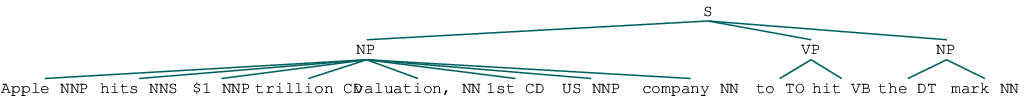

In [57]:
display(chunk_tree)

In [58]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
in token.rights]))

[]<---Apple[nsubj]--->[]
--------
['Apple']<---hits[ROOT]--->['valuation']
--------
[]<---$[quantmod]--->[]
--------
[]<---1[compound]--->[]
--------
['$', '1']<---trillion[nummod]--->[]
--------
['trillion']<---valuation[dobj]--->[',', 'company']
--------
[]<---,[punct]--->[]
--------
[]<---1st[amod]--->[]
--------
[]<---US[compound]--->[]
--------
['1st', 'US']<---company[appos]--->['hit']
--------
[]<---to[aux]--->[]
--------
['to']<---hit[relcl]--->['mark']
--------
[]<---the[det]--->[]
--------
['the']<---mark[dobj]--->[]
--------


In [59]:
from spacy import displacy

In [60]:
displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

In [62]:
from nltk.parse.stanford import StanfordDependencyParser
sdp = StanfordDependencyParser()    

result = list(sdp.raw_parse(sentence))  

# print the dependency tree
dep_tree = [parse.tree() for parse in result][0]
print(dep_tree)

# visualize raw dependency tree
from IPython.display import display
display(dep_tree)

# visualize annotated dependency tree (needs graphviz)
from graphviz import Source
dep_tree_dot_repr = [parse for parse in result][0].to_dot()
source = Source(dep_tree_dot_repr, filename="dep_tree", format="png")
source

/Users/martin/miniconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The StanfordDependencyParser will be deprecated
Please use nltk.parse.corenlp.StanforCoreNLPDependencyParser instead.
  


LookupError: 

===========================================================================
  NLTK was unable to find stanford-parser\.jar! Set the CLASSPATH
  environment variable.

  For more information, on stanford-parser\.jar, see:
    <https://nlp.stanford.edu/software/lex-parser.shtml>
===========================================================================

In [63]:
sentence = str(news_df.iloc[1].full_text)
sentence_nlp = nlp(sentence)

# print named entities in article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(Apple, 'ORG'), ($, 'MONEY'), (1, 'MONEY'), (trillion, 'MONEY'), (US, 'GPE'), (Apple, 'ORG'), (Thursday, 'DATE'), (first, 'ORDINAL'), (US, 'GPE'), ($, 'MONEY'), (1, 'MONEY'), (trillion, 'MONEY'), (207.05, 'MONEY'), (Apple, 'ORG'), (Chinese, 'NORP'), (PetroChina, 'ORG'), (first, 'ORDINAL'), ($, 'MONEY'), (1, 'MONEY'), (trillion, 'MONEY'), (2007, 'DATE')]


In [64]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

In [65]:
entity_frame = pd.DataFrame(named_entities, 
columns=['Entity Name', 'Entity Type'])

In [66]:
# get the top named entities
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

0    1        2       3       4        5      6            7   \
Entity Name  Apple   US    first  Indian   Kohli  England  India  Virat Kohli   
Entity Type    ORG  GPE  ORDINAL    NORP  PERSON      GPE    GPE       PERSON   
Frequency       19   18       15      11      11       10     10            9   

                8         9      10           11          12        13  \
Entity Name  Greek       two  China  Imran Khans  Team India  Thursday   
Entity Type   NORP  CARDINAL    GPE       PERSON         ORG      DATE   
Frequency        8         6      6            5           5         5   

                    14  
Entity Name  Instagram  
Entity Type    PRODUCT  
Frequency            5

In [67]:
# get the top named entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

0    1    2     3         4     5      6        7        8   \
Entity Type  PERSON  ORG  GPE  DATE  CARDINAL  NORP  MONEY  ORDINAL  PRODUCT   
Frequency       167  118  117    79        65    61     32       31        8   

                9        10   11    12   13           14  
Entity Type  EVENT  PERCENT  LOC  TIME  LAW  WORK_OF_ART  
Frequency        5        4    4     3    3            3

In [68]:
from afinn import Afinn

In [70]:
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                               
                        count      mean       std   min  25%  50%  75%   max
news_category                                                               
sports                   25.0  0.920000  7.135124 -12.0 -5.0  2.0  3.0  17.0
technology               24.0  0.916667  4.179834 -11.0  0.0  1.0  4.0   8.0
world                    25.0 -2.960000  4.217819 -13.0 -6.0 -2.0  0.0   5.0

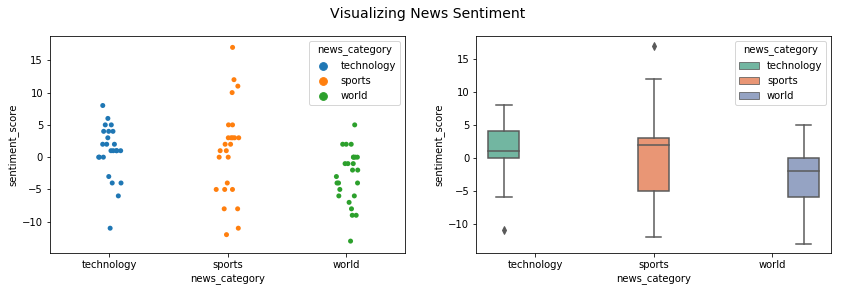

In [71]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

/Users/martin/miniconda3/envs/nlp/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


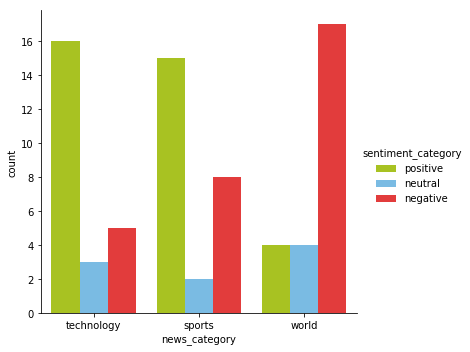

In [73]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [110]:
category = 'technology'

In [111]:
pos_idx = df[(df.news_category==category) & (df.sentiment_score == df[df.news_category==category].sentiment_score.max())].index[0]
neg_idx = df[(df.news_category==category) & (df.sentiment_score == df[df.news_category==category].sentiment_score.min())].index[0]

print('Most Negative ' + category + ' News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive ' + category + ' News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative technology News Article: US-based fitness startup Naked Labs, which makes 3D body scanning mirrors, has raised $14 million in funding. The Series A round was led by Founders Fund, with participation from investors including NEA, Lumia Capital, and Seabed VC. The $1,395 body-scanner consists of a weight scale which spins around while the connected mirror scans a user's body in 15 seconds.

Most Positive technology News Article: Talking about Instagram's Stories feature, the photo-sharing platform's CEO Kevin Systrom said, "I think the mistake everyone made was to think that Stories was a photography product." Adding that the company introduced many interactive features to Stories, Systrom also said, "We've really innovated and made it our own." Notably, Instagram Stories was launched on August 2, 2016. 


<b> Sentiment analysis with TextBlob </b>

In [104]:
from textblob import TextBlob

In [105]:
# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]

In [106]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                                  \
                        count     mean       std    min    25%     50%    75%   
news_category                                                                   
sports                   25.0  0.10392  0.179251 -0.300  0.000  0.0830  0.250   
technology               24.0  0.09350  0.145384 -0.250  0.000  0.0965  0.182   
world                    25.0  0.01512  0.116004 -0.312 -0.046  0.0050  0.067   

                      
                 max  
news_category         
sports         0.460  
technology     0.400  
world          0.312

/Users/martin/miniconda3/envs/nlp/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


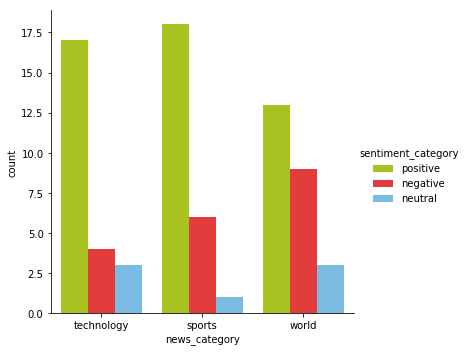

In [108]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [112]:
category = 'technology'
pos_idx = df[(df.news_category==category) & (df.sentiment_score == df[df.news_category==category].sentiment_score.max())].index[0]
neg_idx = df[(df.news_category==category) & (df.sentiment_score == df[df.news_category==category].sentiment_score.min())].index[0]

print('Most Negative ' + category + ' News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive ' + category + ' News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative technology News Article: US-based fitness startup Naked Labs, which makes 3D body scanning mirrors, has raised $14 million in funding. The Series A round was led by Founders Fund, with participation from investors including NEA, Lumia Capital, and Seabed VC. The $1,395 body-scanner consists of a weight scale which spins around while the connected mirror scans a user's body in 15 seconds.

Most Positive technology News Article: Talking about Instagram's Stories feature, the photo-sharing platform's CEO Kevin Systrom said, "I think the mistake everyone made was to think that Stories was a photography product." Adding that the company introduced many interactive features to Stories, Systrom also said, "We've really innovated and made it our own." Notably, Instagram Stories was launched on August 2, 2016. 


In [130]:
ls

2018-08-01-mtb-tds-nlp-tutorial-part1.ipynb
__pycache__/
contractions.py
model_evaluation_utils.py


In [131]:
import model_evaluation_utils as meu2

In [132]:
meu2.display_confusion_matrix(true_labels=sentiment_category, 
                                    predicted_labels=sentiment_category_tb, 
                                    classes=['negative', 'neutral', 'positive'])

                 Predicted:                 
                   negative neutral positive
Actual: negative         12       4       14
        neutral           2       2        5
        positive          5       1       29
